# TELL Analysis of 2012 Heat Wave

This notebook processes and makes plots of the temporal evolution of load during the course of the 2012 heat wave in the U.S.

In [1]:
# Start by importing required packages and information about your operating system:
import os 
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from datetime import timedelta


## Set the Directory Structure

In [2]:
# Identify the top-level data input and output directories:
tell_data_input_dir =  '/Users/burl878/Documents/Code/code_repos/ntp_heat_wave/data/tell_data/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/ntp_heat_wave/plots'

# If the "image_output_dir" subdirectory doesn't exist then create it:
if not os.path.exists(image_output_dir):
   os.makedirs(image_output_dir)


## Set the Balancing Authority and Scenario You Want to Plot

In [63]:
# Give the abbreviation for the BA you want to analyze:
ba_to_plot = 'PSCO'

# Set the scenario you want to analyze:
scenario = 'without_population_effects'


## Process the Load Data for Time Series Plotting

In [64]:
# Read in the historical load data:
if scenario == 'with_population_effects': 
   hist_df = pd.read_csv((tell_data_input_dir + 'with_population_effects/' + 'BA_Loads_2012_With_Population_Effects.csv'))
   fut_df = pd.read_csv((tell_data_input_dir + 'with_population_effects/' + 'BA_Loads_2052_With_Population_Effects.csv'))
else:
   hist_df = pd.read_csv((tell_data_input_dir + 'without_population_effects/' + 'BA_Loads_2012_Without_Population_Effects.csv'))
   fut_df = pd.read_csv((tell_data_input_dir + 'without_population_effects/' + 'BA_Loads_2052_Without_Population_Effects.csv'))
    
hist_df = hist_df.loc[hist_df['BA'].isin([ba_to_plot])].copy()
hist_df['Year'] = pd.DatetimeIndex(hist_df['Time_UTC']).year
hist_df['Month'] = pd.DatetimeIndex(hist_df['Time_UTC']).month
hist_df['Day'] = pd.DatetimeIndex(hist_df['Time_UTC']).day
hist_df['Hour'] = pd.DatetimeIndex(hist_df['Time_UTC']).hour

fut_df = fut_df.loc[fut_df['BA'].isin([ba_to_plot])].copy()
fut_df['Year'] = pd.DatetimeIndex(fut_df['Time_UTC']).year
fut_df['Month'] = pd.DatetimeIndex(fut_df['Time_UTC']).month
fut_df['Day'] = pd.DatetimeIndex(fut_df['Time_UTC']).day
fut_df['Hour'] = pd.DatetimeIndex(fut_df['Time_UTC']).hour
    
plot_df = pd.merge(hist_df, fut_df, how='left', on=['BA', 'Month', 'Day', 'Hour'])
plot_df['date'] = plot_df[["Year_x","Month","Day","Hour"]].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
plot_df['Time_UTC'] = pd.to_datetime(plot_df['date'], format='%Y-%m-%d-%H')

# Compute the normalized loads:
plot_df['rcp45cooler_ssp3_norm'] = 100 * (plot_df['rcp45cooler_ssp3'].div(plot_df['historic']) - 1)
plot_df['rcp45cooler_ssp5_norm'] = 100 * (plot_df['rcp45cooler_ssp5'].div(plot_df['historic']) - 1)
plot_df['rcp45hotter_ssp3_norm'] = 100 * (plot_df['rcp45hotter_ssp3'].div(plot_df['historic']) - 1)
plot_df['rcp45hotter_ssp5_norm'] = 100 * (plot_df['rcp45hotter_ssp5'].div(plot_df['historic']) - 1)
plot_df['rcp85cooler_ssp3_norm'] = 100 * (plot_df['rcp85cooler_ssp3'].div(plot_df['historic']) - 1)
plot_df['rcp85cooler_ssp5_norm'] = 100 * (plot_df['rcp85cooler_ssp5'].div(plot_df['historic']) - 1)
plot_df['rcp85hotter_ssp3_norm'] = 100 * (plot_df['rcp85hotter_ssp3'].div(plot_df['historic']) - 1)
plot_df['rcp85hotter_ssp5_norm'] = 100 * (plot_df['rcp85hotter_ssp5'].div(plot_df['historic']) - 1)

# Only keep the columns that are needed:
plot_df = plot_df[['Time_UTC', 'historic', 
                   'rcp45cooler_ssp3', 'rcp45cooler_ssp3_norm', 
                   'rcp45cooler_ssp5', 'rcp45cooler_ssp5_norm',
                   'rcp45hotter_ssp3', 'rcp45hotter_ssp3_norm',
                   'rcp45hotter_ssp5', 'rcp45hotter_ssp5_norm',
                   'rcp85cooler_ssp3', 'rcp85cooler_ssp3_norm', 
                   'rcp85cooler_ssp5', 'rcp85cooler_ssp5_norm',
                   'rcp85hotter_ssp3', 'rcp85hotter_ssp3_norm',
                   'rcp85hotter_ssp5', 'rcp85hotter_ssp5_norm']].copy()

# Compute the date of the peak historical load:
peak_day = plot_df['Time_UTC'].loc[plot_df['historic'].idxmax()] 
min_date = pd.to_datetime(peak_day) - timedelta(days=3.5)
max_date = pd.to_datetime(peak_day) + timedelta(days=3.5)

# Compute the annual minimum and maximum loads:
min_load = 0.95*plot_df['historic'].min()
max_load = 1.05*plot_df['historic'].max()

# Return the dataframe:
plot_df


,Time_UTC,historic,rcp45cooler_ssp3,rcp45cooler_ssp3_norm,rcp45cooler_ssp5,rcp45cooler_ssp5_norm,rcp45hotter_ssp3,rcp45hotter_ssp3_norm,rcp45hotter_ssp5,rcp45hotter_ssp5_norm,rcp85cooler_ssp3,rcp85cooler_ssp3_norm,rcp85cooler_ssp5,rcp85cooler_ssp5_norm,rcp85hotter_ssp3,rcp85hotter_ssp3_norm,rcp85hotter_ssp5,rcp85hotter_ssp5_norm
0,2012-01-01 00:00:00,5245.78,5321.36,1.440777,5309.02,1.205540,5307.61,1.178662,5296.65,0.969732,5305.08,1.130432,5293.37,0.907205,5269.52,0.452554,5259.75,0.266309
1,2012-01-01 01:00:00,5428.48,5496.89,1.260205,5488.12,1.098650,5472.65,0.813672,5463.67,0.648248,5469.71,0.759513,5458.80,0.558536,5432.99,0.083080,5426.52,-0.036106
2,2012-01-01 02:00:00,5602.38,5648.33,0.820187,5646.54,0.788236,5618.32,0.284522,5614.46,0.215623,5623.78,0.381981,5617.09,0.262567,5577.60,-0.442312,5572.62,-0.531203
3,2012-01-01 03:00:00,5620.33,5521.23,-1.763242,5523.68,-1.719650,5490.68,-2.306804,5490.85,-2.303779,5498.26,-2.171937,5496.41,-2.204853,5467.10,-2.726352,5465.39,-2.756778
4,2012-01-01 04:00:00,5435.04,5281.05,-2.833282,5280.28,-2.847449,5255.05,-3.311659,5253.30,-3.343858,5263.75,-3.151587,5260.42,-3.212856,5233.12,-3.715152,5231.16,-3.751214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2012-12-31 19:00:00,5981.38,5866.81,-1.915444,5854.17,-2.126767,5926.77,-0.913000,5924.56,-0.949948,5863.67,-1.967941,5853.07,-2.145157,5847.73,-2.234434,5836.63,-2.420010
8780,2012-12-31 20:00:00,5936.86,5871.73,-1.097045,5862.75,-1.248303,5909.06,-0.468261,5909.93,-0.453607,5857.23,-1.341281,5846.86,-1.515953,5852.93,-1.413710,5844.31,-1.558905
8781,2012-12-31 21:00:00,5897.64,5869.03,-0.485109,5863.50,-0.578876,5869.45,-0.477988,5867.39,-0.512917,5847.44,-0.851188,5838.31,-1.005996,5836.53,-1.036177,5831.50,-1.121466
8782,2012-12-31 22:00:00,5908.04,5863.43,-0.755073,5856.57,-0.871186,5853.39,-0.925011,5848.52,-1.007441,5847.32,-1.027752,5836.98,-1.202768,5834.62,-1.242713,5828.54,-1.345624


## Make the Time Series Plots

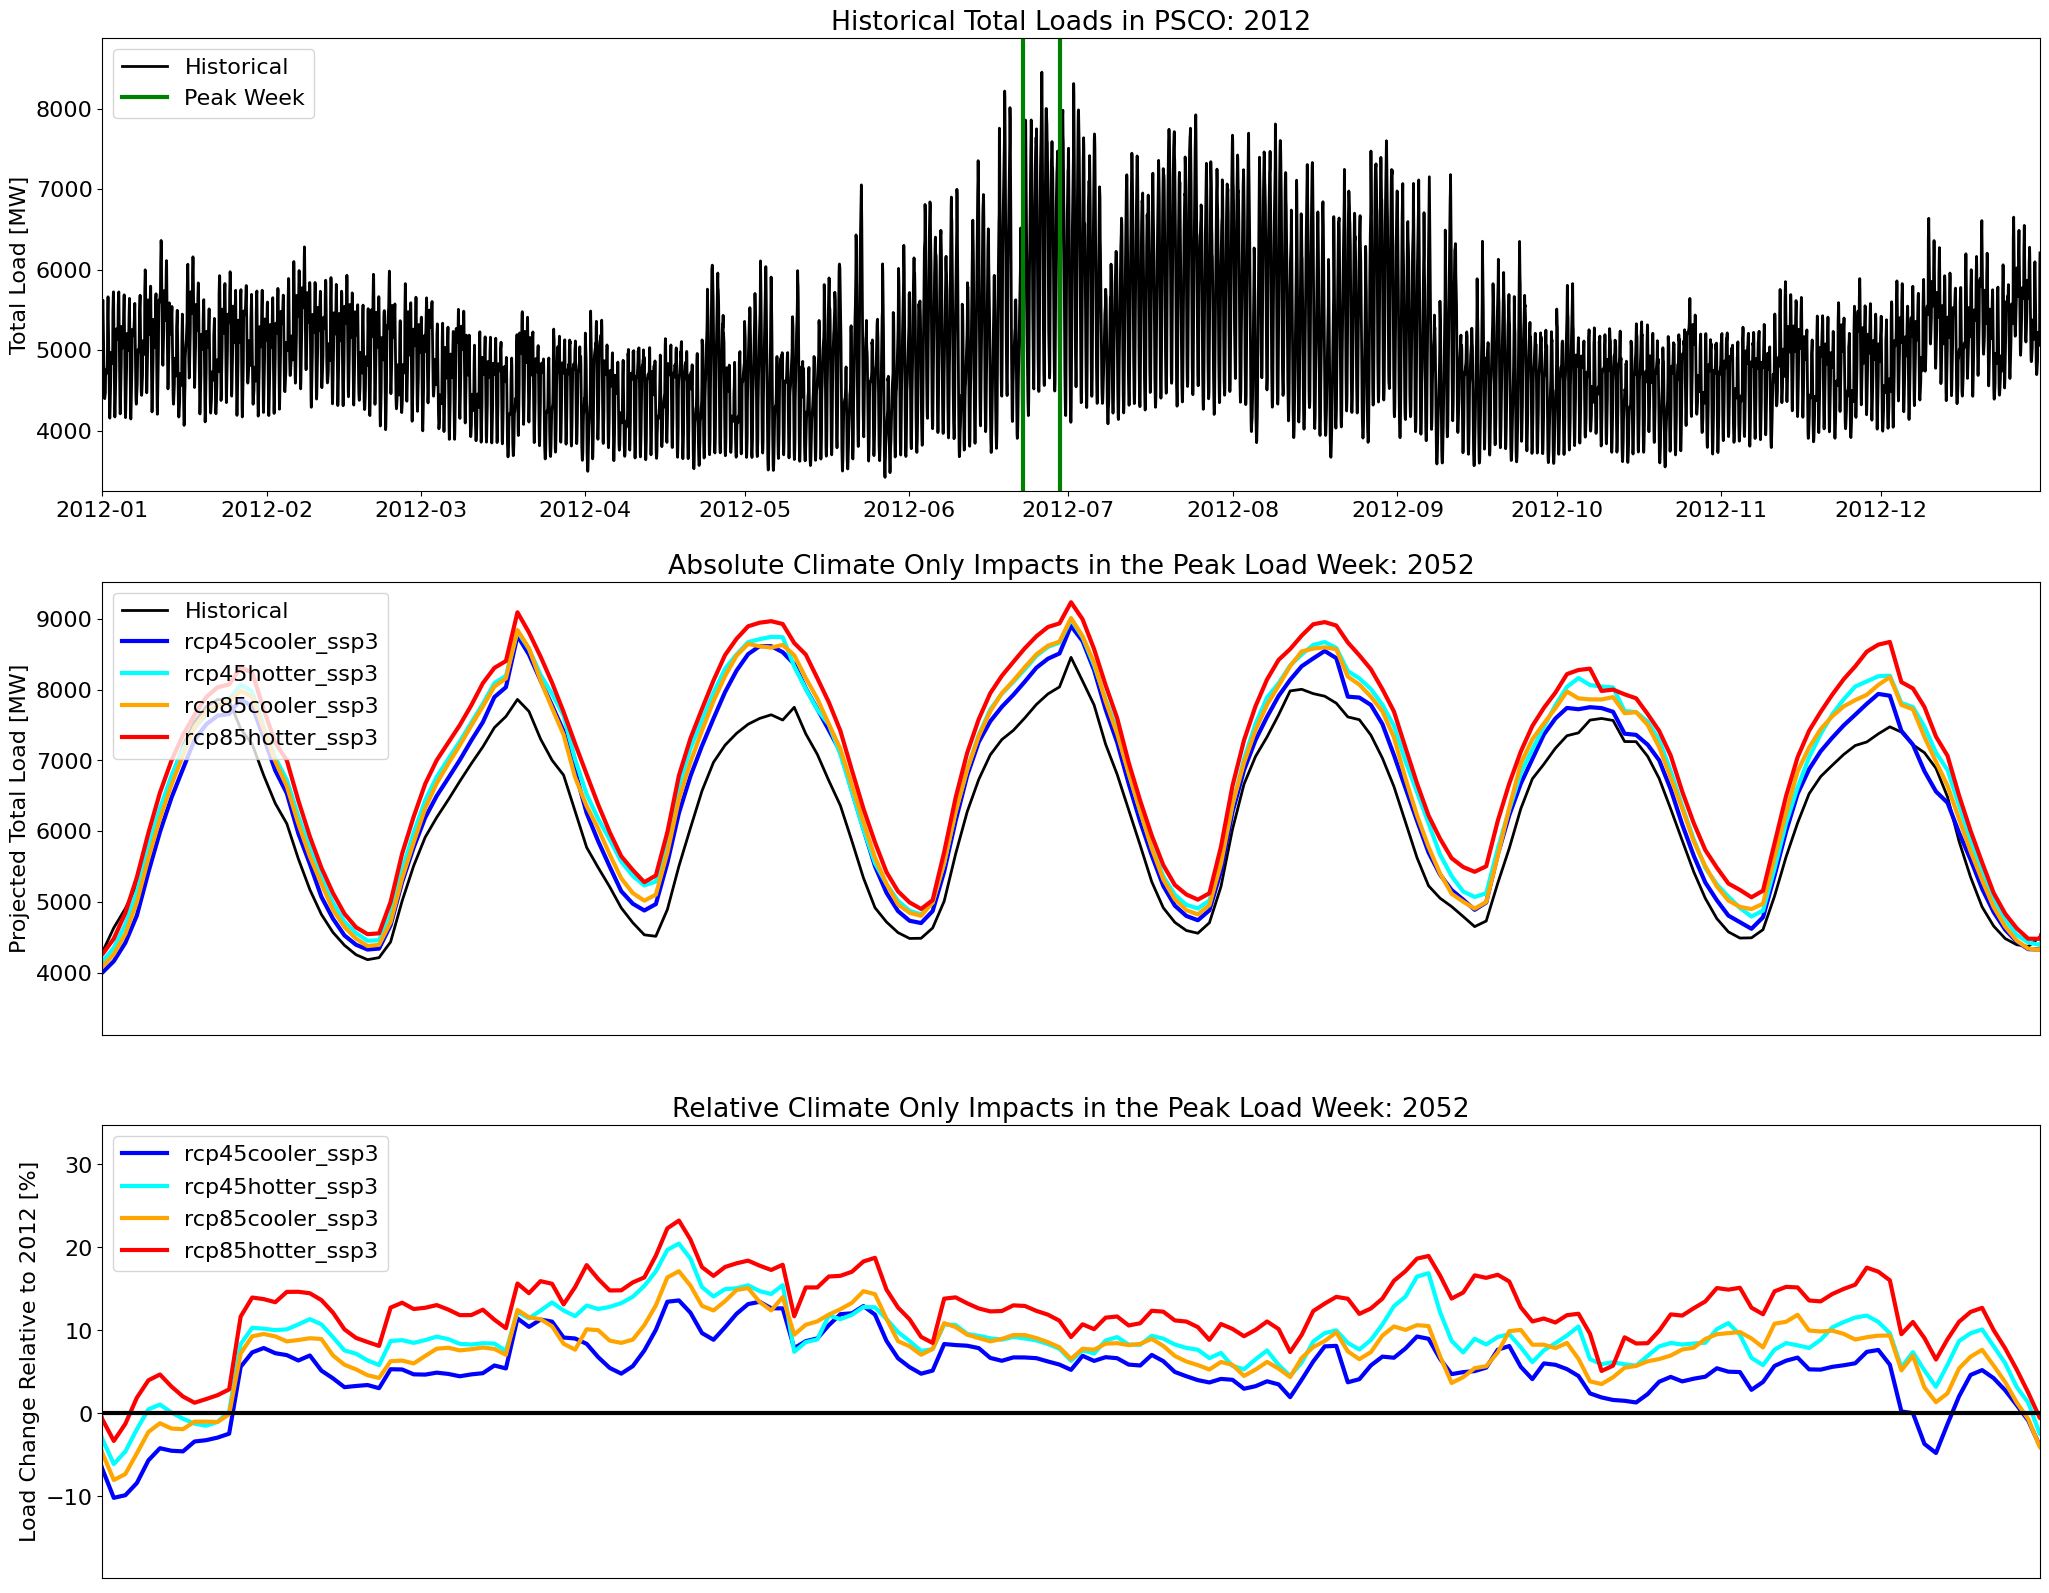

In [65]:
# Make the plot:
plt.figure(figsize=(25, 20))
plt.rcParams['font.size'] = 16
plt.subplot(3,1,1)
plt.plot(plot_df['Time_UTC'], plot_df['historic'], color='k', linestyle='-', label='Historical', linewidth=2)
plt.plot([min_date, min_date], [min_load, max_load], color='g', linestyle='-', label='Peak Week', linewidth=3)
plt.plot([max_date, max_date], [min_load, max_load], color='g', linestyle='-', linewidth=3)
plt.ylim([min_load, max_load])
plt.xlim([datetime.date(2012, 1, 1), datetime.date(2012, 12, 31)])
plt.legend(loc='upper left')
plt.xlabel('')
plt.ylabel('Total Load [MW]')
plt.title(('Historical Total Loads in ' + ba_to_plot + ': 2012'))

plt.subplot(3,1,2)
plt.plot(plot_df['Time_UTC'], plot_df['historic'], color='k', linestyle='-', label='Historical', linewidth=2)
if scenario == 'with_population_effects':
   plt.plot(plot_df['Time_UTC'], plot_df['rcp45cooler_ssp3'], color='b', linestyle='-', label='rcp45cooler_ssp3', linewidth=3)
   plt.plot(plot_df['Time_UTC'], plot_df['rcp45cooler_ssp5'], color='b', linestyle=':', label='rcp45cooler_ssp5', linewidth=3)
   plt.plot(plot_df['Time_UTC'], plot_df['rcp45hotter_ssp3'], color='cyan', linestyle='-', label='rcp45hotter_ssp3', linewidth=3)
   plt.plot(plot_df['Time_UTC'], plot_df['rcp45hotter_ssp5'], color='cyan', linestyle=':', label='rcp45hotter_ssp5', linewidth=3)
   plt.plot(plot_df['Time_UTC'], plot_df['rcp85cooler_ssp3'], color='orange', linestyle='-', label='rcp85cooler_ssp3', linewidth=3)
   plt.plot(plot_df['Time_UTC'], plot_df['rcp85cooler_ssp5'], color='orange', linestyle=':', label='rcp85cooler_ssp5', linewidth=3)
   plt.plot(plot_df['Time_UTC'], plot_df['rcp85hotter_ssp3'], color='red', linestyle='-', label='rcp85hotter_ssp3', linewidth=3)
   plt.plot(plot_df['Time_UTC'], plot_df['rcp85hotter_ssp5'], color='red', linestyle=':', label='rcp85hotter_ssp5', linewidth=3)
else:
   plt.plot(plot_df['Time_UTC'], plot_df['rcp45cooler_ssp3'], color='b', linestyle='-', label='rcp45cooler_ssp3', linewidth=3)
   plt.plot(plot_df['Time_UTC'], plot_df['rcp45hotter_ssp3'], color='cyan', linestyle='-', label='rcp45hotter_ssp3', linewidth=3)
   plt.plot(plot_df['Time_UTC'], plot_df['rcp85cooler_ssp3'], color='orange', linestyle='-', label='rcp85cooler_ssp3', linewidth=3)
   plt.plot(plot_df['Time_UTC'], plot_df['rcp85hotter_ssp3'], color='red', linestyle='-', label='rcp85hotter_ssp3', linewidth=3)
plt.xlim([min_date, max_date])
plt.legend(loc='upper left')
plt.xticks([])
plt.xlabel('')
plt.ylabel('Projected Total Load [MW]')
if scenario == 'with_population_effects':
   plt.title(('Absolute Climate and Socioeconomic Impacts in the Peak Load Week: 2052'))
else:
   plt.title(('Absolute Climate Only Impacts in the Peak Load Week: 2052'))

plt.subplot(3,1,3)
if scenario == 'with_population_effects':
   plt.plot(plot_df['Time_UTC'], plot_df['rcp45cooler_ssp3_norm'], color='b', linestyle='-', label='rcp45cooler_ssp3', linewidth=3)
   plt.plot(plot_df['Time_UTC'], plot_df['rcp45cooler_ssp5_norm'], color='b', linestyle=':', label='rcp45cooler_ssp5', linewidth=3)
   plt.plot(plot_df['Time_UTC'], plot_df['rcp45hotter_ssp3_norm'], color='cyan', linestyle='-', label='rcp45hotter_ssp3', linewidth=3)
   plt.plot(plot_df['Time_UTC'], plot_df['rcp45hotter_ssp5_norm'], color='cyan', linestyle=':', label='rcp45hotter_ssp5', linewidth=3)
   plt.plot(plot_df['Time_UTC'], plot_df['rcp85cooler_ssp3_norm'], color='orange', linestyle='-', label='rcp85cooler_ssp3', linewidth=3)
   plt.plot(plot_df['Time_UTC'], plot_df['rcp85cooler_ssp5_norm'], color='orange', linestyle=':', label='rcp85cooler_ssp5', linewidth=3)
   plt.plot(plot_df['Time_UTC'], plot_df['rcp85hotter_ssp3_norm'], color='red', linestyle='-', label='rcp85hotter_ssp3', linewidth=3)
   plt.plot(plot_df['Time_UTC'], plot_df['rcp85hotter_ssp5_norm'], color='red', linestyle=':', label='rcp85hotter_ssp5', linewidth=3)
else:
   plt.plot(plot_df['Time_UTC'], plot_df['rcp45cooler_ssp3_norm'], color='b', linestyle='-', label='rcp45cooler_ssp3', linewidth=3)
   plt.plot(plot_df['Time_UTC'], plot_df['rcp45hotter_ssp3_norm'], color='cyan', linestyle='-', label='rcp45hotter_ssp3', linewidth=3)
   plt.plot(plot_df['Time_UTC'], plot_df['rcp85cooler_ssp3_norm'], color='orange', linestyle='-', label='rcp85cooler_ssp3', linewidth=3)
   plt.plot(plot_df['Time_UTC'], plot_df['rcp85hotter_ssp3_norm'], color='red', linestyle='-', label='rcp85hotter_ssp3', linewidth=3)
plt.plot([min_date, max_date], [0, 0], color='k', linestyle='-', linewidth=3)
plt.xlim([min_date, max_date])
plt.legend(loc='upper left')
plt.xticks([])
plt.xlabel('')
plt.ylabel('Load Change Relative to 2012 [%]')
if scenario == 'with_population_effects':
   plt.title(('Relative Climate and Socioeconomic Impacts in the Peak Load Week: 2052'))
else:
   plt.title(('Relative Climate Only Impacts in the Peak Load Week: 2052'))

if scenario == 'with_population_effects':
   filename = ('2012_heatwave_' + ba_to_plot + '_with_population_effects.png')
else:
   filename = ('2012_heatwave_' + ba_to_plot + '_without_population_effects.png')

plt.savefig(os.path.join(image_output_dir, filename), dpi=300, bbox_inches='tight', facecolor='white')


## Process the Load Data for BA Histogram Plots

In [98]:
# Set the scenario you want to analyze:
scenario_to_analze = 'rcp85hotter_ssp5'


In [99]:
# Read in the historical load data with population effects:
hist_with_df = pd.read_csv((tell_data_input_dir + 'with_population_effects/' + 'BA_Loads_2012_With_Population_Effects.csv'))
hist_with_df.rename(columns={'historic': 'historic_with_pop'}, inplace=True)
hist_with_df['Year'] = pd.DatetimeIndex(hist_with_df['Time_UTC']).year
hist_with_df['Month'] = pd.DatetimeIndex(hist_with_df['Time_UTC']).month
hist_with_df['Day'] = pd.DatetimeIndex(hist_with_df['Time_UTC']).day
hist_with_df['Hour'] = pd.DatetimeIndex(hist_with_df['Time_UTC']).hour

# Read in the projected load data with population effects:
fut_with_df = pd.read_csv((tell_data_input_dir + 'with_population_effects/' + 'BA_Loads_2052_With_Population_Effects.csv'))
fut_with_df = fut_with_df[['BA', 'Time_UTC', scenario_to_analze]].copy()
fut_with_df.rename(columns={scenario_to_analze: 'future_with_pop'}, inplace=True)
fut_with_df['Year'] = pd.DatetimeIndex(fut_with_df['Time_UTC']).year
fut_with_df['Month'] = pd.DatetimeIndex(fut_with_df['Time_UTC']).month
fut_with_df['Day'] = pd.DatetimeIndex(fut_with_df['Time_UTC']).day
fut_with_df['Hour'] = pd.DatetimeIndex(fut_with_df['Time_UTC']).hour
    
# Read in the historical load data without population effects:
hist_without_df = pd.read_csv((tell_data_input_dir + 'without_population_effects/' + 'BA_Loads_2012_Without_Population_Effects.csv'))
hist_without_df.rename(columns={'historic': 'historic_without_pop'}, inplace=True)
hist_without_df['Year'] = pd.DatetimeIndex(hist_without_df['Time_UTC']).year
hist_without_df['Month'] = pd.DatetimeIndex(hist_without_df['Time_UTC']).month
hist_without_df['Day'] = pd.DatetimeIndex(hist_without_df['Time_UTC']).day
hist_without_df['Hour'] = pd.DatetimeIndex(hist_without_df['Time_UTC']).hour

# Read in the projected load data without population effects:
fut_without_df = pd.read_csv((tell_data_input_dir + 'without_population_effects/' + 'BA_Loads_2052_Without_Population_Effects.csv'))
fut_without_df = fut_without_df[['BA', 'Time_UTC', scenario_to_analze]].copy()
fut_without_df.rename(columns={scenario_to_analze: 'future_without_pop'}, inplace=True)
fut_without_df['Year'] = pd.DatetimeIndex(fut_without_df['Time_UTC']).year
fut_without_df['Month'] = pd.DatetimeIndex(fut_without_df['Time_UTC']).month
fut_without_df['Day'] = pd.DatetimeIndex(fut_without_df['Time_UTC']).day
fut_without_df['Hour'] = pd.DatetimeIndex(fut_without_df['Time_UTC']).hour

# Merge the datasets together based on common BA, year, month, day, and hour combinations:
analysis_df = pd.merge(hist_with_df, fut_with_df, how='left', on=['BA', 'Month', 'Day', 'Hour'])
analysis_df = analysis_df[['BA', 'Year_x', 'Month', 'Day', 'Hour', 'historic_with_pop', 'future_with_pop']].copy()
analysis_df = pd.merge(analysis_df, hist_without_df, how='left', on=['BA', 'Month', 'Day', 'Hour'])
analysis_df = analysis_df[['BA', 'Year_x', 'Month', 'Day', 'Hour', 'historic_with_pop', 'future_with_pop', 'historic_without_pop']].copy()
analysis_df = pd.merge(analysis_df, fut_without_df, how='left', on=['BA', 'Month', 'Day', 'Hour'])
analysis_df = analysis_df[['BA', 'Year_x', 'Month', 'Day', 'Hour', 'historic_with_pop', 'future_with_pop', 'historic_without_pop', 'future_without_pop']].copy()

# Convert the time to a datetime variable:
analysis_df['date'] = analysis_df[['Year_x', 'Month', 'Day', 'Hour']].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
analysis_df['Time_UTC'] = pd.to_datetime(analysis_df['date'], format='%Y-%m-%d-%H')

# Compute the normalized loads:
analysis_df['norm_with_pop'] = 100 * (analysis_df['future_with_pop'].div(analysis_df['historic_with_pop']) - 1)
analysis_df['norm_without_pop'] = 100 * (analysis_df['future_without_pop'].div(analysis_df['historic_without_pop']) - 1)

# Only keep the columns that are needed:
analysis_df = analysis_df[['BA', 'Time_UTC', 
                           'historic_with_pop', 'future_with_pop', 'norm_with_pop',
                           'historic_without_pop', 'future_without_pop', 'norm_without_pop']].copy()

# Return the dataframe
analysis_df


,BA,Time_UTC,historic_with_pop,future_with_pop,norm_with_pop,historic_without_pop,future_without_pop,norm_without_pop
0,AEC,2012-01-01 00:00:00,543.17,704.87,29.769685,496.87,455.62,-8.301970
1,AEC,2012-01-01 01:00:00,578.24,734.00,26.936912,528.95,474.45,-10.303431
2,AEC,2012-01-01 02:00:00,593.55,749.75,26.316233,542.96,484.63,-10.742964
3,AEC,2012-01-01 03:00:00,573.54,707.33,23.327057,524.65,457.21,-12.854284
4,AEC,2012-01-01 04:00:00,543.71,654.51,20.378511,497.37,423.07,-14.938577
...,...,...,...,...,...,...,...,...
474331,WAUW,2012-12-31 19:00:00,97.13,130.07,33.913312,103.55,99.10,-4.297441
474332,WAUW,2012-12-31 20:00:00,96.12,129.02,34.228048,102.47,98.30,-4.069484
474333,WAUW,2012-12-31 21:00:00,95.70,128.52,34.294671,102.02,97.92,-4.018820
474334,WAUW,2012-12-31 22:00:00,96.14,129.12,34.304140,102.49,98.38,-4.010147


In [100]:
# Make a list of all of the BAs in the "analysis_df":
bas = analysis_df['BA'].unique()

# Create an empty dataframe and store the results:
ba_df = pd.DataFrame()
    
# Loop over the BAs and compute their mean effects:
for i in range(len(bas)):
    # Subset to just the data for the BA being processed:
    subset_df = analysis_df[analysis_df['BA'].isin([bas[i]])].copy()
    
    # Compute the date of the peak historical load:
    peak_day = subset_df['Time_UTC'].loc[subset_df['historic_with_pop'].idxmax()] 
    min_date = pd.to_datetime(peak_day) - timedelta(days=3.5)
    max_date = pd.to_datetime(peak_day) + timedelta(days=3.5)
    
    # Subset to only the week around the historical peak load value:
    peak_df = subset_df.loc[(subset_df['Time_UTC'] >= min_date) & (subset_df['Time_UTC'] < max_date)]
    
    # Output the mean difference:
    ba_df.loc[i, 'BA'] = bas[i]
    ba_df.loc[i, 'Mean_With_Pop'] = subset_df['norm_with_pop'].mean().round(2)
    ba_df.loc[i, 'Max_With_Pop'] = subset_df['norm_with_pop'].max().round(2)
    ba_df.loc[i, 'Peak_With_Pop'] = peak_df['norm_with_pop'].mean().round(2)
    ba_df.loc[i, 'Mean_Without_Pop'] = subset_df['norm_without_pop'].mean().round(2)
    ba_df.loc[i, 'Max_Without_Pop'] = subset_df['norm_without_pop'].max().round(2)
    ba_df.loc[i, 'Peak_Without_Pop'] = peak_df['norm_without_pop'].mean().round(2)

# Subset the dataframe to only BAs in the WECC:
ba_df = ba_df[ba_df['BA'].isin(['AVA','AZPS','BANC','BPAT','CHPD','CISO','DEAA','DOPD','EPE',
                                'GCPD','IID','IPCO','LDWP','NEVP','NWMT','PACE','PACW','PGE',
                                'PNM','PSCO','PSEI','SCL','SRP','TEPC','TIDC','TPWR','WACM',
                                'WALC','WAUW'])]
    
# Return the dataframe:
ba_df


,BA,Mean_With_Pop,Max_With_Pop,Peak_With_Pop,Mean_Without_Pop,Max_Without_Pop,Peak_Without_Pop
2,AVA,69.06,121.04,62.94,0.32,31.17,-3.31
3,AZPS,98.22,158.86,103.63,6.75,39.41,9.67
4,BANC,82.41,134.47,98.24,4.69,34.56,13.77
5,BPAT,60.50,92.31,53.01,-1.03,18.59,-5.64
6,CHPD,64.47,126.60,56.91,-1.33,35.94,-5.86
7,CISO,82.29,137.50,90.62,4.57,36.24,9.34
9,DOPD,67.98,113.76,51.95,0.77,28.25,-8.84
11,EPE,68.31,123.51,74.56,5.63,40.27,9.55
16,GCPD,66.80,90.31,73.91,0.07,14.17,4.33
19,IID,88.11,156.37,89.04,7.96,47.13,8.49


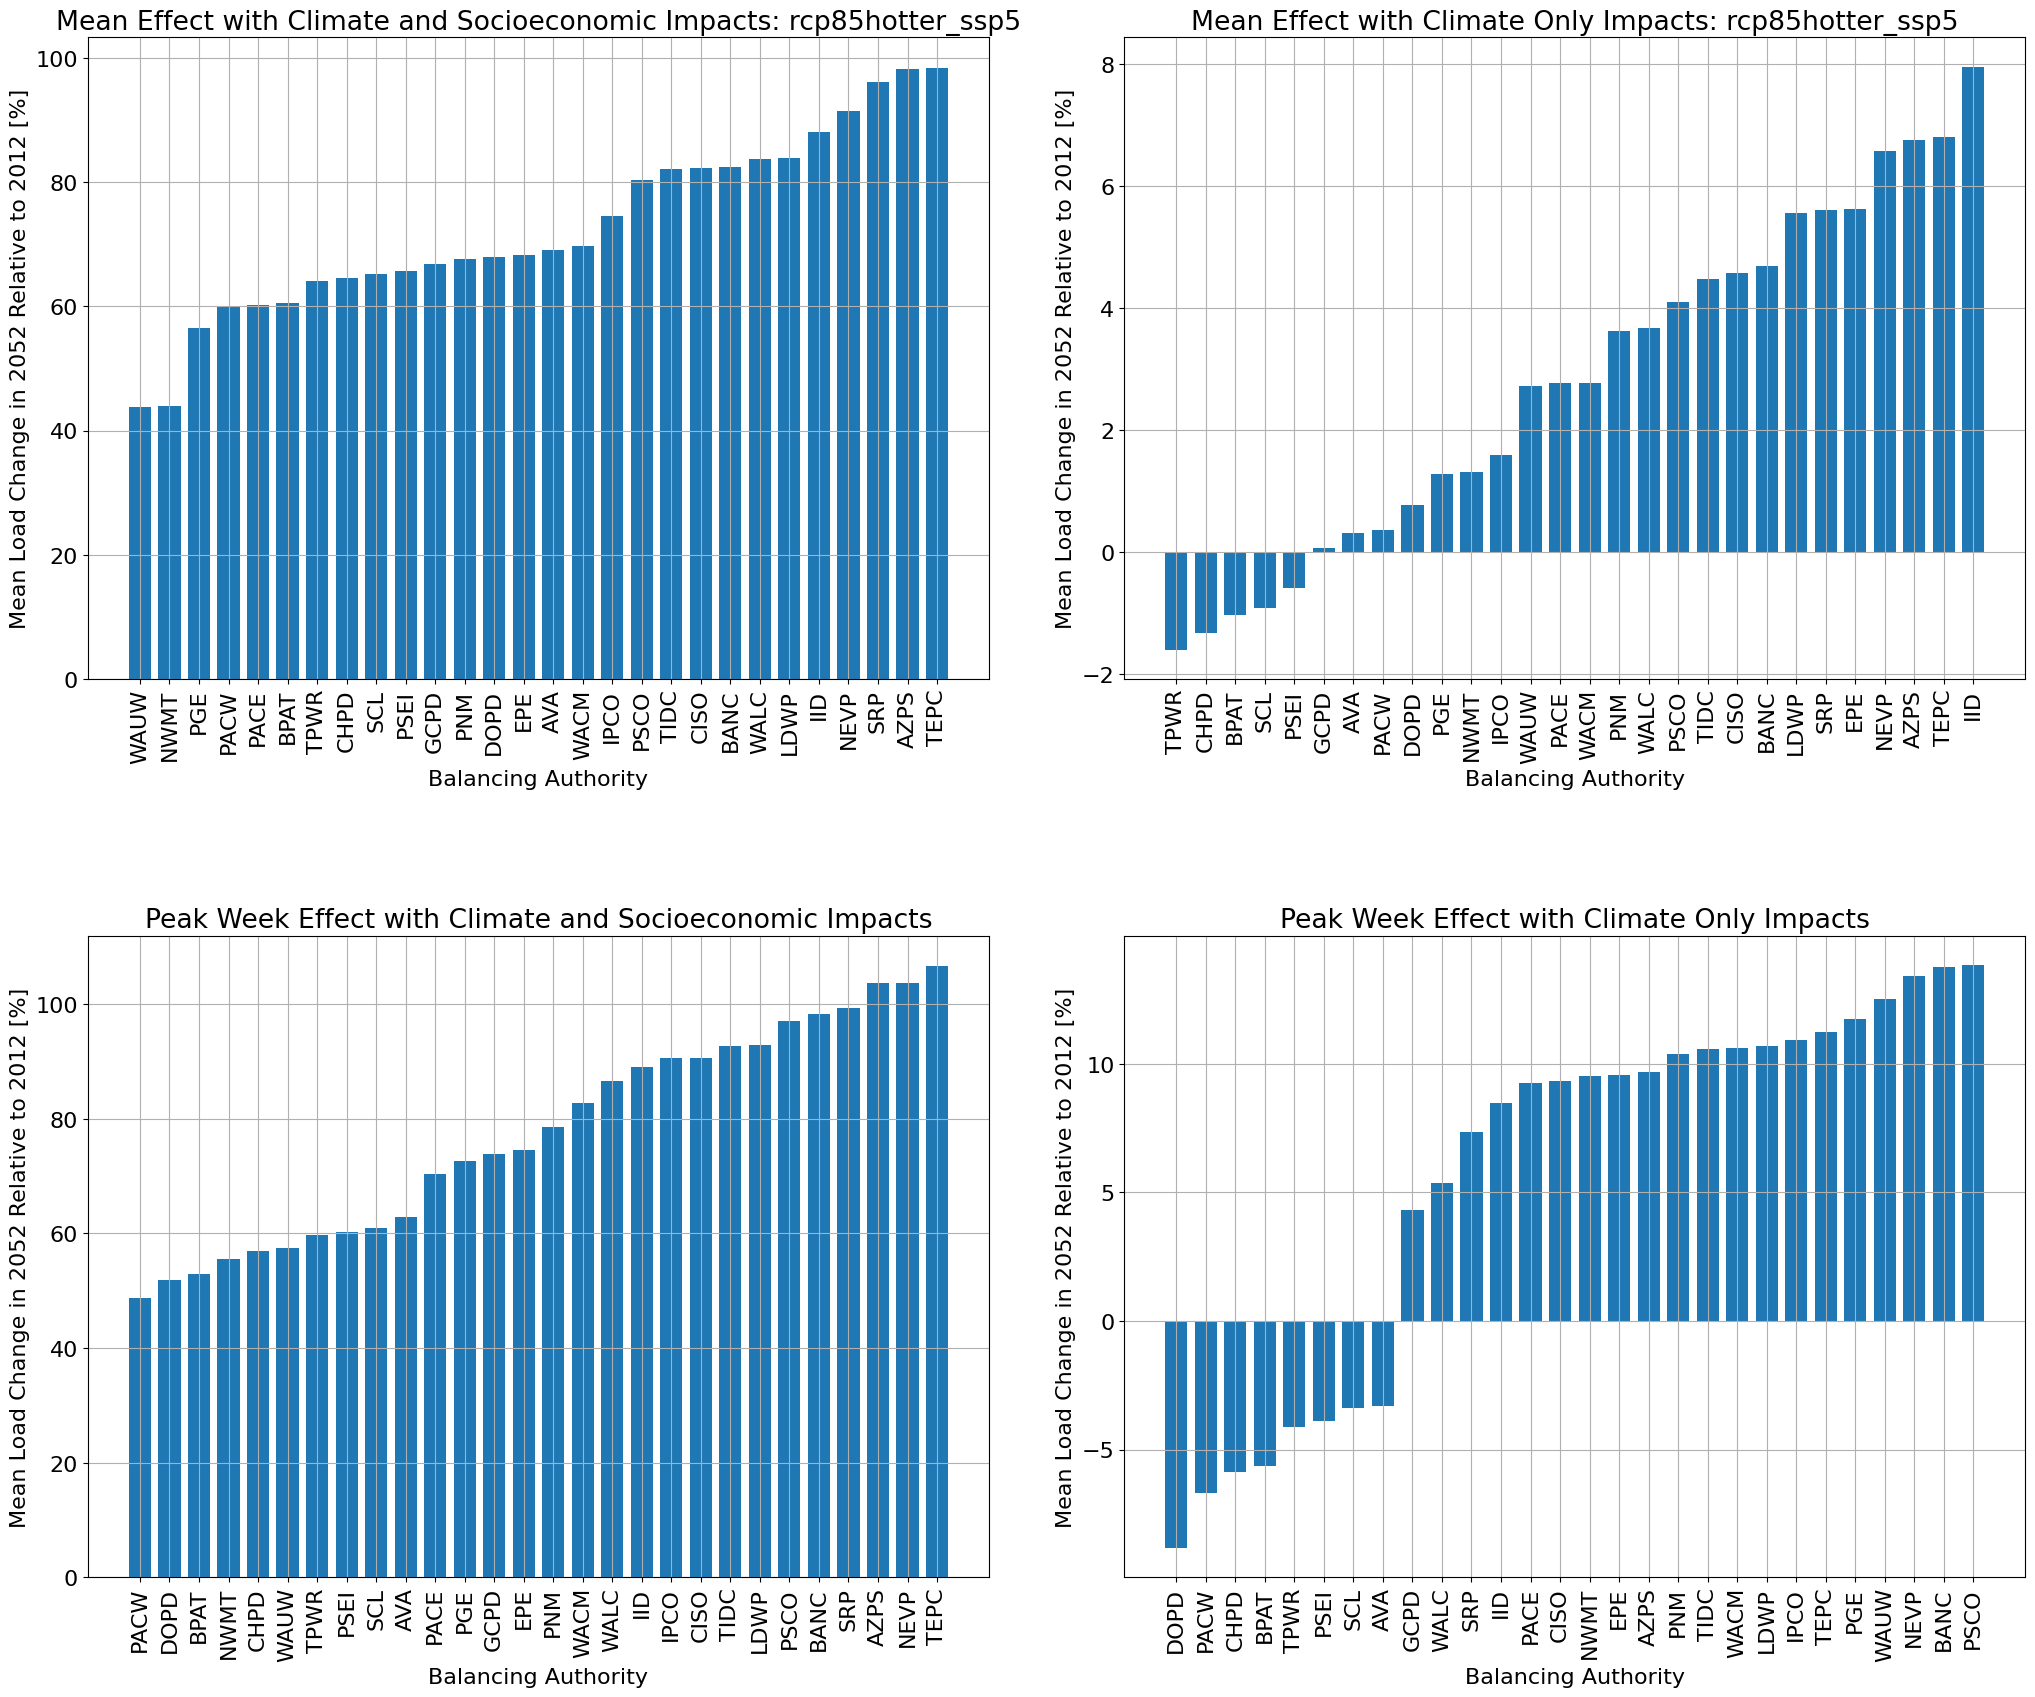

In [101]:
# Create an x-axis the length of the dataframe to be used in plotting:
x_axis = np.arange(len(ba_df))

# Make the plot:
plt.figure(figsize=(25, 20))
plt.subplot(221)
plt.bar(x_axis, ba_df.sort_values(by=['Mean_With_Pop'], ascending=True)['Mean_With_Pop'], 0.75)
plt.xticks(x_axis, ba_df.sort_values(by=['Mean_With_Pop'], ascending=True)['BA'], rotation=90)
plt.grid()
plt.xlabel('Balancing Authority')
plt.ylabel('Mean Load Change in 2052 Relative to 2012 [%]')
plt.title('Mean Effect with Climate and Socioeconomic Impacts: ' + scenario_to_analze)

plt.subplot(222)
plt.bar(x_axis, ba_df.sort_values(by=['Mean_Without_Pop'], ascending=True)['Mean_Without_Pop'], 0.75)
plt.xticks(x_axis, ba_df.sort_values(by=['Mean_Without_Pop'], ascending=True)['BA'], rotation=90)
plt.grid()
plt.xlabel('Balancing Authority')
plt.ylabel('Mean Load Change in 2052 Relative to 2012 [%]')
plt.title('Mean Effect with Climate Only Impacts: ' + scenario_to_analze)

plt.subplot(223)
plt.bar(x_axis, ba_df.sort_values(by=['Peak_With_Pop'], ascending=True)['Peak_With_Pop'], 0.75)
plt.xticks(x_axis, ba_df.sort_values(by=['Peak_With_Pop'], ascending=True)['BA'], rotation=90)
plt.grid()
plt.xlabel('Balancing Authority')
plt.ylabel('Mean Load Change in 2052 Relative to 2012 [%]')
plt.title('Peak Week Effect with Climate and Socioeconomic Impacts')

plt.subplot(224)
plt.bar(x_axis, ba_df.sort_values(by=['Peak_Without_Pop'], ascending=True)['Peak_Without_Pop'], 0.75)
plt.xticks(x_axis, ba_df.sort_values(by=['Peak_Without_Pop'], ascending=True)['BA'], rotation=90)
plt.grid()
plt.xlabel('Balancing Authority')
plt.ylabel('Mean Load Change in 2052 Relative to 2012 [%]')
plt.title('Peak Week Effect with Climate Only Impacts')

plt.subplots_adjust(wspace=0.15, hspace=0.4)

filename = ('BA_Comparison_2052_' + scenario_to_analze + '.png')

plt.savefig(os.path.join(image_output_dir, filename), dpi=300, bbox_inches='tight', facecolor='white')
